In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Считываем датасет
df_full = pd.read_csv('https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/spam.csv')
df_full.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Копируем dataframe в новую переменную, тк мы будем его изменять
df = df_full.copy()

In [4]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [5]:
# Приводим весь текст к нижнему регистру
# Сначала преобразуем значения в столбце к строке, а затем переводим текст в нижний регистр
df['Message'] = df['Message'].str.lower()
df.head()

,Category,Message
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


In [6]:
df['Message'].head(1)

0    go until jurong point, crazy.. available only ...
Name: Message, dtype: object

In [7]:
# Удаляем мусорные символы
# re - библиотека для регулярных выражений
# apply - функция, которая применяемтся к каждой ячейке Message (в данном случае)
# Здесь в каждой ячейке удаляются знаки пунктуации и цифры
df['Message'] = df['Message'].apply(lambda x : re.sub("[^\w\s]", "", x))
df['Message'] = df['Message'].apply(lambda x : re.sub("\d", "", x))
#df['Message'] = df['Message'].apply(lambda x : re.sub("[.|,|!|?|@|#|№|$|;|%|:|^|*|~]", "", x))

In [8]:
df['Message'].head(1)

0    go until jurong point crazy available only in ...
Name: Message, dtype: object

In [9]:
# Загрузка списка стоп-слов
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Первые 20 стоп-слов из общего списка
stop[0:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [11]:
# Удаляем стоп-слова
# x - это текст ячейки. Разбиваем его на список слов по пробелу
# Идем по этому списку и оставляем только те слова, которых нет в списке стоп-слов
# ' '.join([]) - берется каждый элемент из списка в квадртаных скобках и склеивается в строку,
# между элментами ставится символ, указанный перед join (в данном случае пробел)
df['Message'] = df['Message'].apply(lambda x : ' '.join([word for word in x.split() if word not in stop]))

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Amir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# Приводим слова к начальной форме
lemmatizer = WordNetLemmatizer()
df['Message'] = df['Message'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [14]:
# Преобразуем все сообщения в вектора TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df.Message)
names = tfidf.get_feature_names()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)

In [15]:
# разделяем данные на обучающую и тестовую выборки
X = tfidf_matrix.copy()
Y = df['Category'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((3900, 7954), (1672, 7954))

In [16]:
# Создаем модель
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [17]:
# Точность
print(f'Точность = {model.score(X_test, y_test) * 100}%')

Точность = 95.93301435406698%


In [18]:
# Делаем предсказания для тестовой и обучающей выборки
pred_test = model.predict(X_test)

In [19]:
# Строим матрицу неточностей
labels = ['spam', 'ham']
cnf_matrix = confusion_matrix(y_test, pred_test)
print(cnf_matrix)

[[1444    4]
 [  64  160]]


In [20]:
# Преобразуем ее в dataframe
cnf_df = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
cnf_df

,spam,ham
spam,1444,4
ham,64,160


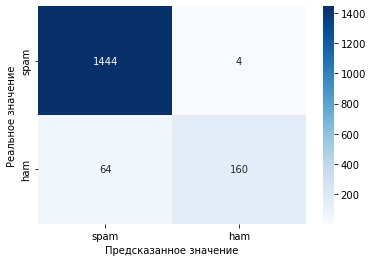

In [21]:
# Рисуем матрицу неточнотсей
sns.heatmap(cnf_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Предсказанное значение')
plt.ylabel('Реальное значение')
plt.show()

In [22]:
# Преобразуем предсказанные значения из nparray в series
pred_test = pd.Series(pred_test)

In [23]:
# y_train и y_test делаем dataframe
y_test = y_test.to_frame()

In [24]:
# Объединяем реальные и предсказанные значения
y_test['pred'] = pred_test.tolist()

In [25]:
# Отфильтровываем неверно предсказанные значения
y_test = y_test[y_test.Category != y_test.pred]
y_test

,Category,pred
2952,ham,spam
881,spam,ham
1961,spam,ham
3864,spam,ham
2575,spam,ham
...,...,...
191,spam,ham
4543,spam,ham
752,spam,ham
495,ham,spam


In [26]:
# Удаляем лишний столбец и сортируем индекс
y_test = y_test.drop(['Category'], axis=1).sort_index()
y_test

,pred
15,ham
19,ham
68,ham
75,spam
95,ham
...,...
4652,ham
5037,ham
5120,ham
5366,ham


In [27]:
# Соединяем полученный датафрейм с основым по индексам
df_wrong_pred = pd.merge(y_test, df_full, left_index=True, right_index=True)
df_wrong_pred

,pred,Category,Message
15,ham,spam,"XXXMobileMovieClub: To use your credit, click ..."
19,ham,spam,England v Macedonia - dont miss the goals/team...
68,ham,spam,"Did you hear about the new ""Divorce Barbie""? I..."
75,spam,ham,I am waiting machan. Call me once you free.
95,ham,spam,Your free ringtone is waiting to be collected....
...,...,...,...
4652,ham,spam,A £400 XMAS REWARD IS WAITING FOR YOU! Our com...
5037,ham,spam,You won't believe it but it's true. It's Incre...
5120,ham,spam,PRIVATE! Your 2003 Account Statement for 078
5366,ham,spam,A £400 XMAS REWARD IS WAITING FOR YOU! Our com...
